# Adaptive Linear Neuron (Adaline)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

## Load the data

In [2]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data', header=None)
# Select only Setosa and Versicolor tags as target values
y = df.iloc[0:100, 4].values
# Change the target labels to numeric data for easy handling
y = np.where(y == 'Iris-setosa', -1, 1)
# Select the Setosa and Versicolor sepal and petal length values
X = df.iloc[0:100, [0, 2]].values

## Adaline Class with Gradient Descent

In [3]:
class AdalineGD:
    def __init__(self, learn_rate=0.1, num_iters=50):
        self.learn_rate = learn_rate
        self.num_iters= num_iters
    
    def fit(self, X, y):
        self.w_ = np.zeros(1 + X.shape[1])
        self.cost_ = []
        for i in range(self.num_iters):
            output = self.net_input(X)
            # Get the error vector
            errors = (y - output)
            # Gradient descent
            self.w_[1:] += self.learn_rate * X.T.dot(errors)
            self.w_[0] += self.learn_rate * errors.sum()
            # Cost function we try to minimize
            cost = (errors**2).sum() / 2
            self.cost_.append(cost)
        return self
    
    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]
    
    def activation(self, X):
        return self.net_input(X)
    
    def predict(self, X):
        return np.where(self.activation(X) >= 0, 1, -1)

## Diference in learning rates

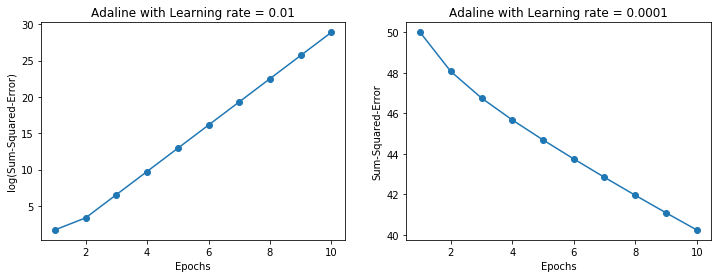

In [4]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
# First Adaline
ada1 = AdalineGD(learn_rate=0.01, num_iters=10).fit(X, y)
ax[0].plot(range(1, len(ada1.cost_)+1), np.log10(ada1.cost_), marker='o')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('log(Sum-Squared-Error)')
ax[0].set_title('Adaline with Learning rate = 0.01')
# Second Adaline
ada2 = Adaline(learn_rate=0.0001, num_iters=10).fit(X, y)
ax[1].plot(range(1, len(ada2.cost_)+1), ada2.cost_, marker='o')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Sum-Squared-Error')
ax[1].set_title('Adaline with Learning rate = 0.0001')
plt.show()

## Standarize features

In [10]:
X_std = np.copy(X)
X_std[:, 0] = (X[:,0] - X[:, 0].mean()) / X[:, 0].std()
X_std[:, 1] = (X[:,1] - X[:, 1].mean()) / X[:, 1].std()

### Decision zone plotting function

In [6]:
def plot_decision_regions(X, y, classifier, resolution=0.02):
    # Setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    # Plot decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    # Use the trained model
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    
    # Some more plotting stuff
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    
    # Plot some class samples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                    alpha=0.8, c=cmap(idx),
                    marker=markers[idx], label=cl)

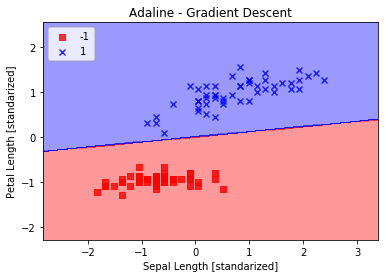

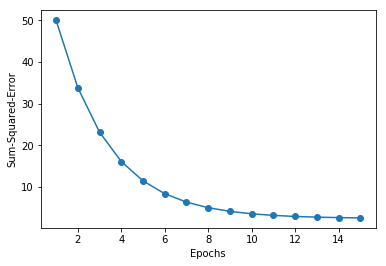

In [11]:
ada = AdalineGD(learn_rate=0.01, num_iters=15)
ada.fit(X_std, y)
plot_decision_regions(X_std, y, classifier=ada)
plt.title('Adaline - Gradient Descent')
plt.xlabel('Sepal Length [standarized]')
plt.ylabel('Petal Length [standarized]')
plt.legend(loc='upper left')
plt.show()
plt.plot(range(1, len(ada.cost_) + 1), ada.cost_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Sum-Squared-Error')
plt.show()

# Adaline Class with Stochastic Gradient Descent

In [24]:
class AdalineSGD:
    def __init__(self, learn_rate=0.1, num_iters=50,
                 shuffle=True, random_state=None):
        self.learn_rate = learn_rate
        self.num_iters= num_iters
        self.w_initialized = False
        self.shuffle = shuffle
        if random_state:
            np.random.seed(random_state)
    
    def fit(self, X, y):
        self._initialize_weights(X.shape[1])
        self.cost_ = []
        for i in range(self.num_iters):
            if self.shuffle:
                X, y = self._shuffle(X, y)
            cost = []
            for xi, target in zip(X, y):
                cost.append(self._update_weights(xi, target))
            avg_cost = sum(cost)/len(y)
            self.cost_.append(avg_cost)
        return self
    
    def partial_fit(self, X, y):
        if not self.w_initialized:
            self._initialie_weights(X.shape[1])
        if y.ravel().shape[0] > 1:
            for xi, target in zip(X, y):
                self._update_weights(xi, target)
        else:
            self._update_weights(X, y)
        return self
    
    def _shuffle(self, X, y):
        r = np.random.permutation(len(y))
        return X[r], y[r]
    
    def _initialize_weights(self, m):
        self.w_ = np.zeros(1 + m)
        self.w_initialized = True
    
    def _update_weights(self, xi, target):
        output = self.net_input(xi)
        error = (target - output)
        self.w_[1:] += self.learn_rate * xi.dot(error)
        self.w_[0] += self.learn_rate * error
        cost = 0.5 * error**2
        return cost
        
    
    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]
    
    def activation(self, X):
        return self.net_input(X)
    
    def predict(self, X):
        return np.where(self.activation(X) >= 0, 1, -1)

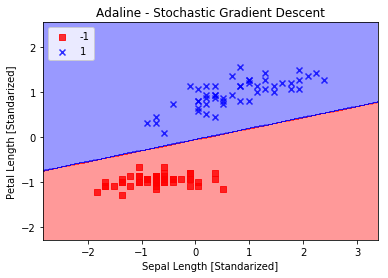

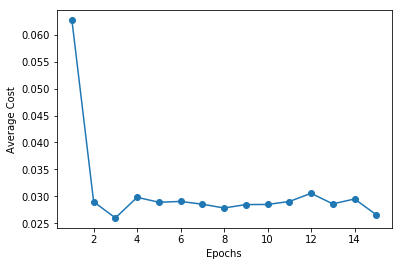

In [28]:
ada_sgd = AdalineSGD(learn_rate=0.1, num_iters=15, random_state=1)
ada_sgd.fit(X_std, y)
plot_decision_regions(X_std, y, classifier=ada_sgd)
plt.title('Adaline - Stochastic Gradient Descent')
plt.xlabel('Sepal Length [Standarized]')
plt.ylabel('Petal Length [Standarized]')
plt.legend(loc='upper left')
plt.show()
plt.plot(range(1, len(ada_sgd.cost_) + 1), ada_sgd.cost_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Average Cost')
plt.show()